# EGARCH-SVM Hybrid Model

Traditional GARCH models capture volatility clustering but struggle with non-linear market dynamics. Machine learning models like SVR can model complex patterns but lack interpretability. This hybrid GARCH-SVM framework:
- Leverages GARCH for parametric volatility estimation
- Uses SVR to model residuals and refine forecasts
- Combines strengths of both approaches for improved accuracy

GARCH provides baseline volatility structure and SVR corrects for GARCH’s limitations in modeling non-linear residuals. Recursive forecasting ensures dynamic updates of both components.

### Load Data

In [35]:
import numpy as np
import pandas as pd
from arch import arch_model
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [36]:
file_path = "..\data\ALGO_daily.csv"
df = pd.read_csv(file_path)
df.rename(columns={'timestamp': 'Date'}, inplace=True)
df.set_index('Date', inplace=True)
df.head(2)

,open,high,low,close,return,RV,lnRV
Date,,,,,,,
2019-06-23,2.190,2.234,1.800,1.934,-0.125224,0.020962,-3.865058
2019-06-24,1.932,2.020,1.301,1.416,-0.311754,0.025926,-3.652501


In [37]:
# Train-Test Split 
dfs = {}
for h in [1, 3, 7, 30]:
    
    df_h = df[['return', 'lnRV']].copy()
    df_h.dropna(inplace=True)

    # Split the data into training and testing sets by the cutoff date
    cutoff_date='2024-01-01'
    r_train, r_test = df_h['return'][:cutoff_date], df_h['return'][cutoff_date:]
    lnRV_train, lnRV_test = df_h['lnRV'].shift(-h)[:cutoff_date], df_h['lnRV'].shift(-h)[cutoff_date:]
    lnRV_test.dropna(inplace=True)
    
    dfs[h] = {'r_train': r_train, 'r_test': r_test, 'lnRV_train': lnRV_train, 'lnRV_test': lnRV_test}
    print(f"Training Set Size for {h}D forecast:", len(r_train), len(lnRV_train))
    print(f"Testing Set Size for {h}D forecast:", len(r_test), len(lnRV_test))
    print(f"Testing Period for {h}D forecast starts on:", r_test.index[0], lnRV_test.index[0])

Training Set Size for 1D forecast: 1654 1654
Testing Set Size for 1D forecast: 425 424
Testing Period for 1D forecast starts on: 2024-01-01 2024-01-01
Training Set Size for 3D forecast: 1654 1654
Testing Set Size for 3D forecast: 425 422
Testing Period for 3D forecast starts on: 2024-01-01 2024-01-01
Training Set Size for 7D forecast: 1654 1654
Testing Set Size for 7D forecast: 425 418
Testing Period for 7D forecast starts on: 2024-01-01 2024-01-01
Training Set Size for 30D forecast: 1654 1654
Testing Set Size for 30D forecast: 425 395
Testing Period for 30D forecast starts on: 2024-01-01 2024-01-01


In [38]:
def predict(log_returns, log_RV, h=1):
    """
    Parameters:
    log_returns (array-like): Daily (log) return series r₁,..rₙ
    log_RV (array-like): Daily log realized variance series lnRV₁,..lnRVₙ
    h (int): Forecast horizon (number of days ahead to predict)
    
    Returns:
     
    """
    # Step 1: Estimate GARCH parameters
    garch_model = arch_model(log_returns, vol='Garch', p=1, q=1, rescale=False)
    garch_results = garch_model.fit(disp='off')
    
    # Step 2: Compute conditional variances σ²₁,..,σ²ₙ
    conditional_variances = garch_results.conditional_volatility**2

    # Step 3: Compute Mₜ = lnRVₜ - ln(σ²ₜ)
    # Note: ln(σ²ₜ) is the log of the conditional variance
    L_sequence = np.log(conditional_variances)
    M_sequence = log_RV - L_sequence
    
    # Step 4: Train SVR model
    # Prepare initial data matrix for SVR training
    X = np.column_stack([
        L_sequence[:-1],            # ln(σ²ₜ₋₁)
        M_sequence[:-1],            # Mₜ₋₁
        log_RV[:-1],                # lnRVₜ₋₁
    ])
    y = M_sequence[1:]              # Mₜ (target)
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Initialize and fit SVR model
    svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    svr_model.fit(X_scaled, y)
    
    # Initialize forecast arrays
    L_forecasts = np.zeros(h)
    M_forecasts = np.zeros(h)
    lnRV_forecasts = np.zeros(h)
    
    # Initialize the most recent data point
    last_L = L_sequence.iloc[-1]
    last_M = M_sequence.iloc[-1]
    last_lnRV = log_RV.iloc[-1]
    
    # Recursive forecasting for h steps
    for i in range(1, h+1):
        # Prepare input for current step
        current_X = np.array([last_L, last_M, last_lnRV]).reshape(1, -1)
        current_X_scaled = scaler.transform(current_X)
        
        # Step 5: Forecast M_{t+i}
        M_forecast = svr_model.predict(current_X_scaled)[0]
        M_forecasts[i-1] = M_forecast
        
        # Step 6: Forecast σ²_{t+i} using GARCH (1-step ahead each iteration)
        sigma_forecast = garch_results.forecast(horizon=1).variance.values[-1, -1]
        
        # Step 7: Compute lnRVₜ = M_{t+i} + ln(σ²_{t+i})
        L_forecast = np.log(sigma_forecast)
        L_forecasts[i-1] = L_forecast
        lnRV_forecast = M_forecast + L_forecast
        lnRV_forecasts[i-1] = lnRV_forecast
        
        # Update inputs for next step (using forecasts as inputs)
        last_L = L_forecast
        last_M = M_forecast
        last_lnRV = lnRV_forecast
        
    return lnRV_forecasts[-1]

In [39]:
def get_pred(h):

    pred = []
    
    r_train, r_test = dfs[h]['r_train'], dfs[h]['r_test']
    lnRV_train, lnRV_test = dfs[h]['lnRV_train'], dfs[h]['lnRV_test']
    
    for i in range(len(lnRV_test)):
        log_returns = pd.concat([r_train, r_test[:i]])
        log_RVs = pd.concat([lnRV_train, lnRV_test[:i]])
        forecast = predict(log_returns, log_RVs, h)
        pred.append(forecast)

    pred = pd.DataFrame(pred, index = r_test.index[h:], columns=['Predicted'])
    pred.to_csv(f'../res/GARCH-SVM_{h}D.csv')
    return pred

In [40]:
def plot_pred(pred, actual, h):
    actual.index = pred.index
    plt.figure(figsize=(8, 3))
    plt.plot(actual, label='Actual')
    plt.plot(pred, label='Predicted')
    plt.xticks(actual.index[::100])
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.title(f'GARCH-SVM_{h}D-Ahead Forecast')
    plt.legend()
    plt.savefig(f'../res/GARCH-SVM_{h}D-Ahead Forecast.png')

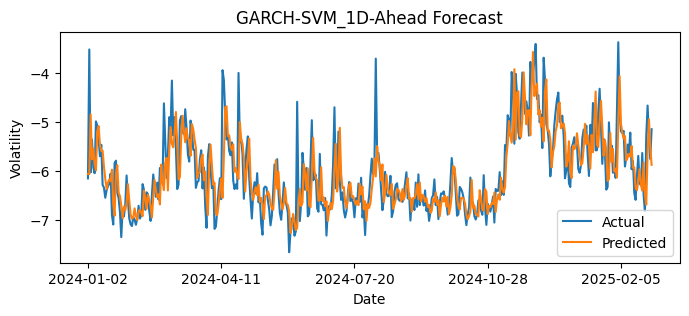

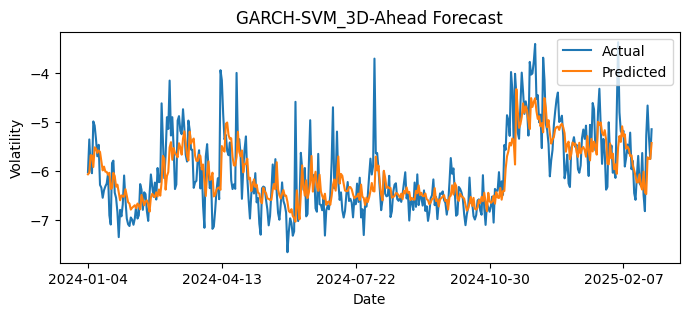

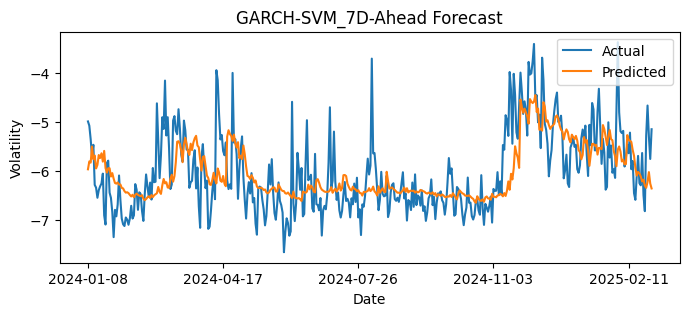

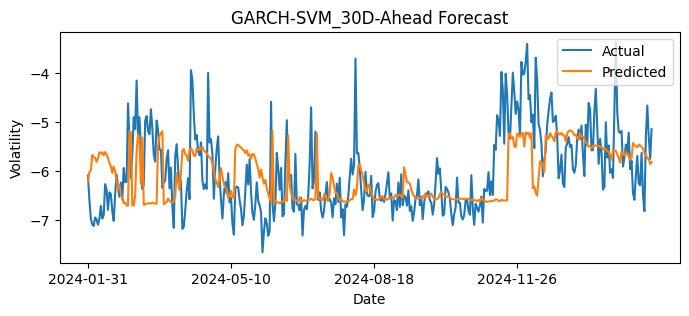

In [41]:
for h in [1,3,7,30]:
    pred = get_pred(h)
    plot_pred(pred, dfs[h]['lnRV_test'], h)